In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from copy import deepcopy
from functools import partial
from io import BytesIO
import json
import os
import warnings
from glob import glob
import sys


In [3]:
import h5py
import igl
import randomcolor
import trimesh
import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed
import trimesh.transformations as tt


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jdrcw0j4 because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [49]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.utils.abc_utils.hdf5.io_struct as io_struct
import sharpf.data.datasets.sharpf_io as sharpf_io
from sharpf.utils.plotting import display_depth_sharpness, plot_views, get_random_color, illustrate_camera
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.convertor_utils.convertors_io import ViewIO, RangeVisionIO
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.utils.camera_utils.view import CameraView
from sharpf.data.imaging import RaycastingImaging
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.camera_utils.camera_pose import CameraPose, camera_to_display
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.convertor_utils.convertors_io import (
    AnnotatedViewIO,
    ViewIO,
    write_annotated_views_to_hdf5)
from sharpf.utils.abc_utils.abc.feature_utils import (
    compute_features_nbhood,
    remove_boundary_features,
    submesh_from_hit_surfaces)
from sharpf.utils.convertor_utils.meshlab_project_parsers import load_meshlab_project
import sharpf.utils.convertor_utils.rangevision_utils as rv_utils
from sharpf.utils.camera_utils import matrix

from sharpf.utils.numpy_utils.transformations import transform_to_frame


In [5]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r, 
                      plot=None, display=True,
                     max_distance_to_feature=1.0):
    
    if None is plot:
        plot = k3d.plot(height=plot_height, camera_auto_fit=True)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances and not np.all(samples_distances == 1.0):
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            v = -np.array([0., 1., 0.])
            max_dist = np.max(np.dot(samples, v))
            min_dist = np.min(np.dot(samples, v))
            colors = k3d.helpers.map_colors(
                np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)

        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            colors = [(c, c) for c in colors]

            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width,
                colors=colors)
#             print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    if display:
        plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))
    
    return plot

In [53]:
def convert_to_fusion_compatible_io(
    input_dataset_filename,
    output_dataset_filename,
):
    input_dataset = Hdf5File(
        input_dataset_filename,
        io=AnnotatedViewIO,
        preload=PreloadTypes.LAZY,
        labels='*')
    
    patches = [{
        'image': image['points'], 
        'distances': image['distances'],
        'camera_pose': image['extrinsics']
    } for image in input_dataset]

    schema_datasets = {
        'image': io_struct.Float64('image'),
        'distances': io_struct.Float64('distances'),
        'camera_pose': io_struct.Float64('camera_pose'),
    }
    WholeDepthMapIO = io_struct.HDF5IO(
        schema_datasets,
        len_label='image',
        compression='lzf')
    def save_whole_images(filename, patches):
        collate_fn = partial(io_struct.collate_mapping_with_io, io=WholeDepthMapIO)
        patches = collate_fn(patches)
        with h5py.File(filename, 'w') as f:
            for key in ['image', 'distances', 'camera_pose']:
                WholeDepthMapIO.write(f, key, patches[key].numpy())

    save_whole_images(output_dataset_filename, patches)
        
    print(output_dataset_filename)

In [55]:
convert_to_fusion_compatible_io(
    '/logs/synth_sharpf_scans/6side_folder_preprocessed_synth.hdf5',
    '/logs/synth_sharpf_scans/6side_folder_preprocessed_synth_io.hdf5'
)

/logs/synth_sharpf_scans/6side_folder_preprocessed_synth_io.hdf5


In [56]:
schema_datasets = {
    'image': io_struct.Float64('image'),
    'distances': io_struct.Float64('distances'),
    'camera_pose': io_struct.Float64('camera_pose'),
}
WholeDepthMapIO = io_struct.HDF5IO(
    schema_datasets,
    len_label='image',
    compression='lzf')
    
ground_truth_dataset = Hdf5File(
    '/logs/synth_sharpf_scans/6side_folder_preprocessed_synth_io.hdf5',
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')
gt_dataset = [view for view in ground_truth_dataset]
# depth images captured from a variety of views around the 3D shape
gt_images = [view['image'] for view in gt_dataset]
# ground-truth distances (multi-view consistent for the global 3D shape)
gt_distances = [view.get('distances', np.ones_like(view['image'])) for view in gt_dataset]
# extrinsic camera matrixes describing the 3D camera poses used to capture depth images
gt_extrinsics = [view['camera_pose'] for view in gt_dataset]
# intrinsic camera parameters describing how to compute image from points and vice versa
gt_intrinsics = [dict(resolution_image=gt_images[0].shape[::-1], resolution_3d=0.5) for view in
                 gt_dataset]


In [39]:
# s = 128

# depth_images_for_display = [
#     image[
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
#     for image in gt_images
# ]
# sharpness_images_for_display = [
#     distances[
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
#     for distances in gt_distances
# ]

# display_depth_sharpness(
#     depth_images=depth_images_for_display,
#     sharpness_images=sharpness_images_for_display,
#     ncols=1,
#     axes_size=(6, 6),
#     max_sharpness=10.0)

In [19]:
def kill_background(distances, image):
    distances_image = distances.copy()
    distances = np.zeros_like(distances_image)
    distances[np.nonzero(image)] = distances_image[np.nonzero(image)]
    return distances

In [17]:
predictions_dataset = Hdf5File(
    '/logs/images_fused/6side_folder_preprocessed_synth__predictions.hdf5',
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')
# pred_distances = [kill_background(view['distances'], image) 
#                   for view, image in zip(predictions_dataset, gt_images)]
pred_distances = [view['distances'] for view in predictions_dataset]

File /logs/images_fused/6side_folder_preprocessed_synth__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>
File /logs/images_fused/6side_folder_preprocessed_synth__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>


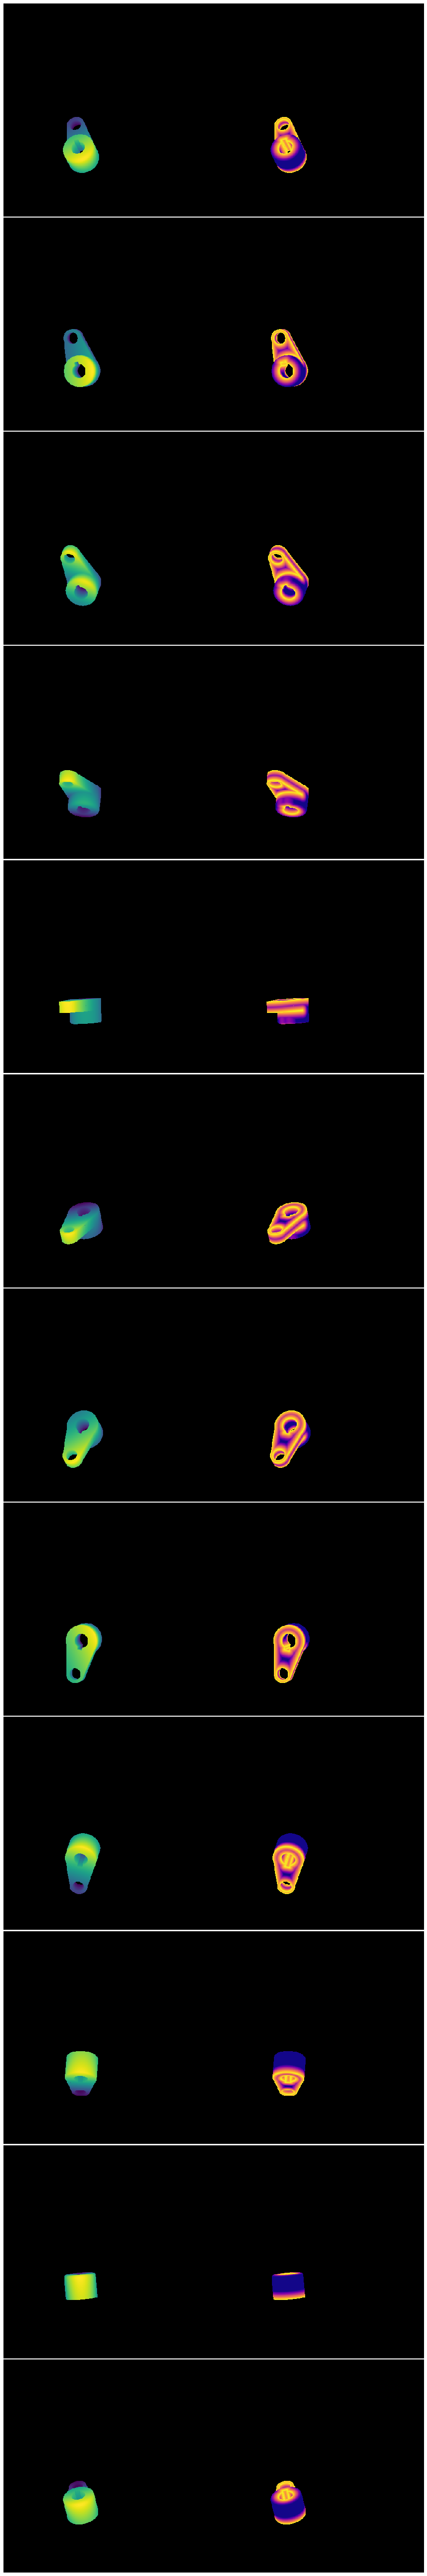

In [60]:
rx, ry = pred_distances[0].shape[::-1]
sx = sy = 512
slices = slice(ry // 2 - sy // 2, ry // 2 + sy // 2),\
         slice(rx // 2 - sx // 2, rx // 2 + sx // 2)

display_depth_sharpness(
    depth_images=[image[slices] for image in gt_images],
#     sharpness_images=[distances[slices] for distances in pred_distances],
    sharpness_images=[kill_background(distances[slices], image[slices])
         for distances, image in zip(gt_distances, gt_images)],
    max_sharpness=10.1,
    axes_size=(6, 6), 
    ncols=1,
    bgcolor='black',
    sharpness_hard_thr=None,
    sharpness_hard_values=(0.1, 10.0))

In [57]:
from typing import Callable, List, Mapping, Tuple

def get_view(
        images: List[np.array],
        distances: List[np.array],
        extrinsics: List[np.array],
        intrinsics_dict: List[Mapping],
        i):
    """A helper function to conveniently prepare view information."""
    image_i = images[i]  # [h, w]
    distances_image_i = distances[i]  # [h, w]
    # Kill background for nicer visuals
    distances_i = np.zeros_like(distances_image_i)
    distances_i[np.nonzero(image_i)] = distances_image_i[np.nonzero(image_i)]

    pose_i = CameraPose(extrinsics[i])
    imaging_i = RaycastingImaging(**intrinsics_dict[i])
    points_i = pose_i.camera_to_world(imaging_i.image_to_points(image_i))

    return image_i, distances_i, points_i, pose_i, imaging_i



def interpolate_ground_truth(
        images: List[np.array],
        distances: List[np.array],
        extrinsics: List[np.array],
        intrinsics_dict: List[Mapping],
):
    # Partially specify view extraction parameters.
    get_view_local = partial(get_view, images, distances, extrinsics, intrinsics_dict)

    fused_points_gt = []
    fused_predictions_gt = []
    for view_index in range(len(images)):
        image_i, distances_i, points_i, pose_i, imaging_i = get_view_local(view_index)
        fused_points_gt.append(points_i)
        fused_predictions_gt.append(distances_i.ravel()[np.flatnonzero(image_i)])

    fused_points_gt = np.concatenate(fused_points_gt)
    fused_predictions_gt = np.concatenate(fused_predictions_gt)

    return fused_points_gt, fused_predictions_gt


In [58]:
print('Fusing ground truth data...')
fused_points_gt, fused_distances_gt = interpolate_ground_truth(
    gt_images,
    gt_distances,
    gt_extrinsics,
    gt_intrinsics)
n_points = len(fused_points_gt)
n_points

Fusing ground truth data...


90854

In [59]:
_ = display_sharpness(
    samples=fused_points_gt,
    samples_psize=0.25,
    samples_distances=fused_distances_gt,
    max_distance_to_feature=10.0)

Output()

In [50]:
# imaging = RaycastingImaging(
#     resolution_image=depth_images[0]['points'].shape[::-1],
#     resolution_3d=0.5, 
#     projection=None, 
#     validate_image=False)


images, distances, extrinsics, intrinsics_dict = gt_images, gt_distances, gt_extrinsics, gt_intrinsics
get_view_local = partial(get_view, images, distances, extrinsics, intrinsics_dict)

plot = k3d.plot(grid_visible=True, height=768)

for view_index in range(len(images)):
    image_i, distances_i, points_i, pose_i, imaging_i = get_view_local(view_index)

    plot += k3d.points(
        points_i,
        point_size=0.25,
        color=get_random_color(hue='green'),
        shader='flat')

    plot += illustrate_camera(
        pose_i,
        l=2000,
        w=10)

plot.display()

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [ ]:
# imaging = RaycastingImaging(
#     resolution_image=rv_utils.RV_SPECTRUM_CAM_RESOLUTION, 
#     resolution_3d=0.5, 
#     projection=None, 
#     validate_image=False)


# plot = k3d.plot(grid_visible=True, height=768)

# for patch in patches:        
#     points = imaging.image_to_points(patch['image'])
#     pose = CameraPose(patch['camera_pose'])
    
#     plot += k3d.points(
#         pose.camera_to_world(points),
#         point_size=0.25,
#         color=get_random_color(hue='green'),
#         shader='flat')
    
# #     plot += illustrate_camera(pose, w=10, l=2000)

# plot.display()



In [ ]:
images_dataset = Hdf5File(
    '/logs/synth_sharpf_scans/6side_folder_preprocessed_synth.hdf5',
    io=AnnotatedViewIO,
    preload=PreloadTypes.LAZY,
    labels='*')

In [ ]:
# s = 128

# depth_images_for_display = [
#     item['points'][
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
#     for item in images_dataset
# ]
# sharpness_images_for_display = [
#     item['distances'][
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
#     for item in images_dataset
# ]

# display_depth_sharpness(
#     depth_images=depth_images_for_display,
#     sharpness_images=sharpness_images_for_display,
#     ncols=1,
#     axes_size=(12, 12),
#     max_sharpness=max_distance_to_feature)

In [ ]:
from sharpf.utils.py_utils.os import change_ext

In [ ]:
output_filename = change_ext(dataset_preprocessed.filename, '') + '_synth.hdf5'
